In [1]:
# Standard modules
import numpy as np
import pandas as pd
import string
import re
import nltk
import matplotlib.pyplot as plt

# Twitter tagger APIs
from modules.CMUTweetTagger import runtagger_parse

# Matplotlib setup
%matplotlib inline

In [2]:
# Constants

# Path to POS tagger java application
ARK_TWEET_NLP_PATH = 'java -XX:ParallelGCThreads=2 -Xmx500m -jar resources/ark-tweet-nlp-0.3.2/ark-tweet-nlp-0.3.2.jar'

# Path to words dataset .csv file
WORDS_PATH = 'data/database/words.csv'

In [3]:
# Load tweets dataset
tweets = pd.read_csv('data/database/tweets.csv', dtype={
    'id_str': np.unicode_,
    'created_at': np.unicode_
})

# Parse created_at attribute to Datetime format
tweets.created_at = pd.to_datetime(tweets.created_at, format='%a %b %d %H:%M:%S %z %Y')

# Sort by date descending
tweets.sort_values(by='created_at', ascending=False, inplace=True)

# Show few lines of the dataset
tweets.head()

,created_at,id_str,text,truncated,geo,coordinates,place,retweet_count,favourite_count,in_reply_to_status_id_str,in_reply_to_user_id_str,lang
0,2018-06-30 22:35:06+00:00,1013189209488797697,"#PrideMonth may be ending today, but we will c...",True,NaN,NaN,NaN,73,NaN,NaN,NaN,en
1,2018-06-30 19:35:07+00:00,1013143915308953606,“This disaster leaves us in extreme poverty......,True,NaN,NaN,NaN,28,NaN,NaN,NaN,en
2,2018-06-30 18:35:07+00:00,1013128815575470081,We want more women on ballots 🗳️ when we go ou...,True,NaN,NaN,NaN,56,NaN,NaN,NaN,en
3,2018-06-30 16:35:09+00:00,1013098625768009728,“The idea that sexism &amp; misogyny in online...,True,NaN,NaN,NaN,107,NaN,NaN,NaN,en
4,2018-06-30 15:05:12+00:00,1013075989885341697,"When women are targeted online, the abuse is m...",True,NaN,NaN,NaN,209,NaN,NaN,NaN,en


In [4]:
# Show last lines of the dataset
tweets.tail()

,created_at,id_str,text,truncated,geo,coordinates,place,retweet_count,favourite_count,in_reply_to_status_id_str,in_reply_to_user_id_str,lang
2040,2017-04-01 13:35:13+00:00,848166865415352320,"Maria had almost given up, then she found supp...",False,NaN,NaN,NaN,33,NaN,NaN,NaN,en
2041,2017-04-01 10:35:05+00:00,848121534204039169,"Parental leave, childcare ███ part-time work p...",True,NaN,NaN,NaN,51,NaN,NaN,NaN,en
2042,2017-04-01 07:35:03+00:00,848076227571331072,Inclusion of women at highest levels of int'l ...,False,NaN,NaN,NaN,68,NaN,NaN,NaN,en
2043,2017-04-01 04:35:03+00:00,848030929482285056,Op-Ed: 3 simple things men can do to support w...,False,NaN,NaN,NaN,53,NaN,NaN,NaN,en
2044,2017-04-01 01:35:11+00:00,847985662850723840,These teens in Bangladesh are taking it into t...,False,NaN,NaN,NaN,95,NaN,NaN,NaN,en


In [5]:
# Define wrapper function for POS tagging words in tweets
def pos_tag(tweets):
    return runtagger_parse(tweets, run_tagger_cmd=ARK_TWEET_NLP_PATH)

In [6]:
# Tag each tweet in dataset
tagged_tweets = pos_tag(tweets.loc[:, 'text'].values)
tagged_tweets[:5]

[[('#PrideMonth', '#', 0.6107),
  ('may', 'V', 0.917),
  ('be', 'V', 0.9994),
  ('ending', 'V', 0.9877),
  ('today', 'N', 0.9923),
  (',', ',', 0.9986),
  ('but', '&', 0.9959),
  ('we', 'O', 0.9986),
  ('will', 'V', 0.9991),
  ('continue', 'V', 0.9994),
  ('to', 'P', 0.9846),
  ('advocate', 'N', 0.7117),
  ('for', 'P', 0.9997),
  ("everyone's", 'L', 0.3268),
  ('right', 'R', 0.547),
  ('to', 'P', 0.9983),
  ('live', 'V', 0.9708),
  ('as', 'P', 0.9699),
  ('their', 'D', 0.9307),
  ('true', 'A', 0.9824),
  ('self', 'N', 0.9933),
  ('every', 'D', 0.9676),
  ('day', 'N', 0.9991),
  (',', ',', 0.9991),
  ('everywhere', 'R', 0.9935),
  ('.', ',', 0.9978),
  ('Join', 'V', 0.9982),
  ('us', 'O', 0.9294),
  (':', ',', 0.6608),
  ('https://t.co/rm4EvjQRyk', 'U', 0.9803),
  ('https://t.co/kbrhXRXL7P', 'U', 0.9976)],
 [('“', ',', 0.9691),
  ('This', 'D', 0.9658),
  ('disaster', 'N', 0.9943),
  ('leaves', 'V', 0.9793),
  ('us', 'O', 0.9639),
  ('in', 'P', 0.9561),
  ('extreme', 'A', 0.9485),
  ('po

In [7]:
# Turn each tuple into a dictionary

# Define new list containing tagged words
tagged_words = list()
# Loop through each tagged tweet
for i, tagged_tweet in enumerate(tagged_tweets):
    # Get current tweet id
    tweet_id = tweets.loc[i, 'id_str']
    # Loop through each tag in current tweet
    for j, tag in enumerate(tagged_tweet):
        # Overwrite tag tuple with word dictionary
        tagged_word = {
            'tweet': tweet_id, # Id of tweet containing word
            'index': j, # Word index in sentence
            'text': tag[0], # Actual word text
            'pos': tag[1], # Part Of Speech tag
            'conf': tag[2], # Confidence for POS tag
        }
        # Update tagged words list
        tagged_words.append(tagged_word)
    
# Show first 5 tagged tweets objects
tagged_words[:5]

[{'tweet': '1013189209488797697',
  'index': 0,
  'text': '#PrideMonth',
  'pos': '#',
  'conf': 0.6107},
 {'tweet': '1013189209488797697',
  'index': 1,
  'text': 'may',
  'pos': 'V',
  'conf': 0.917},
 {'tweet': '1013189209488797697',
  'index': 2,
  'text': 'be',
  'pos': 'V',
  'conf': 0.9994},
 {'tweet': '1013189209488797697',
  'index': 3,
  'text': 'ending',
  'pos': 'V',
  'conf': 0.9877},
 {'tweet': '1013189209488797697',
  'index': 4,
  'text': 'today',
  'pos': 'N',
  'conf': 0.9923}]

In [8]:
# Turn tagged words list into a Pandas DataFrame object
words = pd.DataFrame(tagged_words)
words.head()

,tweet,index,text,pos,conf
0,1013189209488797697,0,#PrideMonth,#,0.6107
1,1013189209488797697,1,may,V,0.9170
2,1013189209488797697,2,be,V,0.9994
3,1013189209488797697,3,ending,V,0.9877
4,1013189209488797697,4,today,N,0.9923


In [9]:
# Sort by tweet id and word index
words.sort_values(by=['tweet', 'index'], ascending=True, inplace=True)
words.head()

,tweet,index,text,pos,conf
18444,1000007326789758987,0,Although,P,0.8143
18445,1000007326789758987,1,Tracy,^,0.9989
18446,1000007326789758987,2,lives,V,0.8726
18447,1000007326789758987,3,in,P,0.9471
18448,1000007326789758987,4,one,$,0.9589


In [10]:
# Remove tags whose confidence is below 0.9
words = words[words.conf > 0.9]
words.shape

(61024, 5)

In [11]:
# Keep only nouns (N), verbs (V), adverbs (R) and adjectives (A)
words = words[words.pos.isin(['N', 'V', 'R', 'A'])]
words.shape

(24524, 5)

In [12]:
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')

# Lowercase all and remove stopwords
words.text = words.text.apply(lambda x: x.lower())  # Lowercase
words = words[~words.text.isin(stopwords)]  # Stopwords romoval
words.shape

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/damiclem/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


(20910, 5)

In [13]:
wnl = nltk.stem.WordNetLemmatizer()

# Lemmatize words
words.text = words.apply(lambda x: wnl.lemmatize(x.text, x.pos.lower()), axis=1)
words.head()

,tweet,index,text,pos,conf
18451,1000007326789758987,7,poor,A,0.9889
18452,1000007326789758987,8,area,N,0.9991
18457,1000007326789758987,13,find,V,0.9979
18461,1000007326789758987,17,community,N,0.9951
18462,1000007326789758987,18,provide,V,0.9899


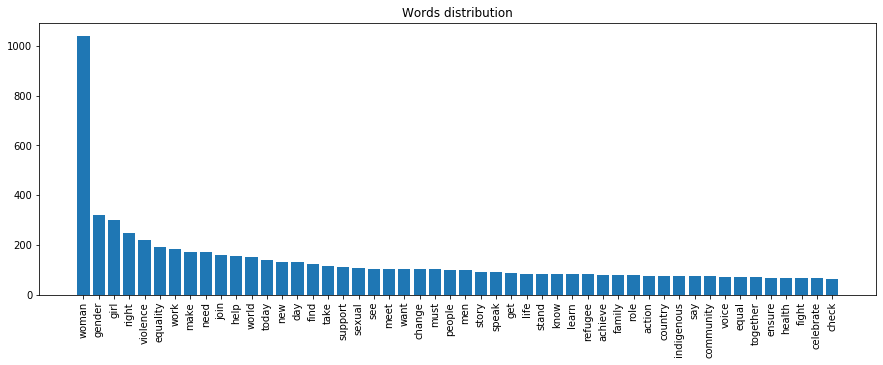

In [14]:
word_counts = words.text.value_counts()
word_counts = word_counts[:50]

# Plot words count
fig, ax = plt.subplots(figsize=(15, 5))
_ = ax.set_title('Words distribution')
_ = ax.bar(x=word_counts.keys().tolist(), height=word_counts.tolist())
_ = ax.tick_params(axis='x', rotation=90)
_ = plt.plot()

In [15]:
# Output to file
words.to_csv(WORDS_PATH, index=False)